<a href="https://colab.research.google.com/github/lahirumanulanka/ann-visual-emotion/blob/created_new_dataset/notebooks/emo_CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ===========================
# Cell 0 — Minimal installs
# ===========================
# If torch/torchvision are already OK in your runtime, this is enough.
!pip -q install timm==1.0.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.2 MB/s eta 0:00:00


In [3]:
# =========================
# Cell 1 — Imports & setup
# =========================
import os, json, math, time, random
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

import timm
from timm.data.mixup import Mixup
from timm.utils import ModelEmaV2

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.rcParams["figure.dpi"] = 120

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=False; torch.backends.cudnn.benchmark=True
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [4]:
# ==============================
# Cell 1.5 — Mount Google Drive
# ==============================
from google.colab import drive
drive.mount('/content/drive')

# CHANGE this path to your project folder on Drive
CANDIDATES = [
    "/content/drive/MyDrive/ann-visual-emotion",
    "/content/drive/MyDrive/Colab Notebooks/ann-visual-emotion",
]
for p in CANDIDATES:
    if os.path.isdir(p): PROJECT_ROOT = p; break
else:
    raise FileNotFoundError("Put the folder 'ann-visual-emotion' in Drive and update CANDIDATES.")

print("PROJECT_ROOT:", PROJECT_ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_ROOT: /content/drive/MyDrive/ann-visual-emotion


In [5]:
# ========================
# Cell 2 — Configuration (memory-safe)
# ========================
from torchvision import transforms, datasets
from pathlib import Path

# ----- DATA FORMAT -----
DATA_FORMAT = "folders"   # or "csv" if you used CSVs

FACES_ROOT   = str(Path(PROJECT_ROOT) / "data" / "processed" / "EmoSet_faces224")
TRAIN_DIR    = str(Path(FACES_ROOT) / "train")
VAL_DIR      = str(Path(FACES_ROOT) / "val")
TEST_DIR     = str(Path(FACES_ROOT) / "test")

TRAIN_CSV = str(Path(PROJECT_ROOT) / "data" / "processed" / "EmoSet_faces_splits" / "train.csv")
VAL_CSV   = str(Path(PROJECT_ROOT) / "data" / "processed" / "EmoSet_faces_splits" / "val.csv")
TEST_CSV  = str(Path(PROJECT_ROOT) / "data" / "processed" / "EmoSet_faces_splits" / "test.csv")
IMAGES_ROOT_FOR_CSV = FACES_ROOT

# ----- Model / data (lighter) -----
BACKBONE      = "convnext_tiny"   # lighter than convnext_base/vit
IMG_SIZE      = 224
BATCH         = 24                # try 24 → 16 if still OOM
ACCUM_STEPS   = 2                 # effective batch = BATCH * ACCUM_STEPS
NUM_WORKERS   = 4
LABEL_SMOOTHING = 0.1

# ----- Optimization -----
EPOCHS          = 40
WARMUP_EPOCHS   = 3
BASE_LR         = 3e-4
WEIGHT_DECAY    = 2e-4

# ----- Imbalance -----
BALANCE_MODE  = "sampler"   # or "none"
LOSS_MODE     = "ce"        # or "focal"
FOCAL_GAMMA   = 2.0

# ----- Augmentation -----
USE_RANDAUG   = True
RANDAUG_N     = 2
RANDAUG_M     = 9
USE_MIXUP     = True
MIXUP_ALPHA   = 0.2
CUTMIX_ALPHA  = 1.0

# ----- EMA & early stopping -----
USE_EMA       = False        # OFF to save memory
EMA_DECAY     = 0.9998
PATIENCE      = 7

# ----- Outputs -----
OUT_DIR = str(Path(PROJECT_ROOT) / "outputs" / "emo_training_faces_direct")
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
print("OUT_DIR:", OUT_DIR)

OUT_DIR: /content/drive/MyDrive/ann-visual-emotion/outputs/emo_training_faces_direct


In [6]:
# =========================================
# Cell 3 — Datasets & DataLoaders (folders)
# =========================================
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
t_train = [transforms.Resize((IMG_SIZE, IMG_SIZE))]
if USE_RANDAUG:
    t_train += [transforms.RandAugment(num_ops=RANDAUG_N, magnitude=RANDAUG_M)]
t_train += [transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            normalize]
t_val = [transforms.Resize((IMG_SIZE, IMG_SIZE)),
         transforms.ToTensor(),
         normalize]

if DATA_FORMAT == "folders":
    train_ds = datasets.ImageFolder(TRAIN_DIR, transform=transforms.Compose(t_train))
    val_ds   = datasets.ImageFolder(VAL_DIR,   transform=transforms.Compose(t_val))
    test_ds  = datasets.ImageFolder(TEST_DIR,  transform=transforms.Compose(t_val)) if os.path.isdir(TEST_DIR) else None
    classes  = train_ds.classes
    num_classes = len(classes)
    print("Classes:", classes)

    # Balanced sampler (recommended with imbalance)
    if BALANCE_MODE == "sampler":
        targets = np.array(train_ds.targets)
        counts = np.bincount(targets, minlength=num_classes)
        inv = 1.0 / np.clip(counts, 1, None)
        sample_weights = inv[targets]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
    else:
        train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

    val_loader  = DataLoader(val_ds,  batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True) if test_ds else None

else:
    # ========= CSV path mode =========
    class CSVFaceDataset(Dataset):
        def __init__(self, csv_path, images_root, transform=None):
            self.df = pd.read_csv(csv_path)
            self.images_root = images_root
            self.transform = transform
            # normalize label -> int (if string)
            if self.df["label"].dtype == object:
                self.labels_str = sorted(self.df["label"].astype(str).unique().tolist())
                self.str2idx = {s:i for i,s in enumerate(self.labels_str)}
                self.df["label_idx"] = self.df["label"].map(self.str2idx).astype(int)
            else:
                self.df["label_idx"] = self.df["label"].astype(int)
                self.labels_str = sorted(self.df["label_idx"].unique().tolist())
                self.str2idx = {str(k):k for k in self.labels_str}
            self.path_col = "image" if "image" in self.df.columns else ("image_path" if "image_path" in self.df.columns else None)
            assert self.path_col is not None, "CSV must have 'image' or 'image_path' column"

        def __len__(self): return len(self.df)
        def __getitem__(self, i):
            row = self.df.iloc[i]
            p = row[self.path_col]
            if not os.path.isabs(p): p = str(Path(self.images_root) / p)
            img = Image.open(p).convert("RGB")
            y = int(row["label_idx"])
            if self.transform is not None: img = self.transform(img)
            return img, y
        @property
        def classes(self):
            # if label strings available, keep them; else numeric strings
            keys = sorted(self.str2idx.values())
            inv = {v:k for k,v in self.str2idx.items()}
            return [inv[k] if k in inv else str(k) for k in keys]

        @property
        def targets(self):
            return self.df["label_idx"].to_numpy()

    train_ds = CSVFaceDataset(TRAIN_CSV, IMAGES_ROOT_FOR_CSV, transform=transforms.Compose(t_train))
    val_ds   = CSVFaceDataset(VAL_CSV,   IMAGES_ROOT_FOR_CSV, transform=transforms.Compose(t_val))
    test_ds  = CSVFaceDataset(TEST_CSV,  IMAGES_ROOT_FOR_CSV, transform=transforms.Compose(t_val)) if (TEST_CSV and Path(TEST_CSV).exists()) else None
    classes  = train_ds.classes
    num_classes = len(classes)
    print("Classes:", classes)

    if BALANCE_MODE == "sampler":
        counts = np.bincount(train_ds.targets, minlength=num_classes)
        inv = 1.0 / np.clip(counts, 1, None)
        sample_weights = inv[train_ds.targets]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
    else:
        train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

    val_loader  = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True) if test_ds else None

Classes: ['0', '1', '2', '3', '4', '5', '6', '7']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
# =========================
# Cell 4 — Model & losses (with optional grad checkpointing)
# =========================
import timm, torch, torch.nn as nn, torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from timm.data.mixup import Mixup

model = timm.create_model(BACKBONE, pretrained=True, num_classes=None, drop_path_rate=0.1)
# Replace classifier head
num_features = model.get_classifier().in_features if hasattr(model, "get_classifier") else model.num_features
model.reset_classifier(num_classes=0)
head = nn.Linear(num_features, 8)  # 8 emotions
model = nn.Sequential(model, nn.Dropout(0.2), head)
model.to(device)

# Optional: gradient checkpointing (saves memory, small speed penalty)
if hasattr(model[0], "set_grad_checkpointing"):
    model[0].set_grad_checkpointing(True)

# Loss
if LOSS_MODE == "ce":
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
else:
    class FocalLoss(nn.Module):
        def __init__(self, gamma=2.0): super().__init__(); self.gamma=gamma
        def forward(self, logits, targets):
            ce = F.cross_entropy(logits, targets, reduction='none')
            pt = torch.exp(-ce)
            return ((1-pt)**self.gamma * ce).mean()
    criterion = FocalLoss(gamma=FOCAL_GAMMA)

# Optimizer & cosine LR with warmup
optimizer = AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
def lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS: return float(epoch+1)/float(max(1,WARMUP_EPOCHS))
    progress = (epoch - WARMUP_EPOCHS) / float(max(1, EPOCHS - WARMUP_EPOCHS))
    return 0.5*(1.0 + math.cos(math.pi*progress))
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

# MixUp/CutMix (timm)
mixup = Mixup(mixup_alpha=MIXUP_ALPHA if USE_MIXUP else 0.0,
              cutmix_alpha=CUTMIX_ALPHA if USE_MIXUP else 0.0,
              label_smoothing=0.0, num_classes=8)

# Mixed precision
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
torch.set_float32_matmul_precision("high")  # speed on Ampere+

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

/tmp/ipython-input-1354223552.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [8]:
# ==================================
# Cell 5 — Train/Eval utilities
# ==================================
def evaluate(m, loader):
    m.eval(); ys=[]; ps=[]
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            logits = m(x)
            pred = torch.argmax(logits,1)
            ys.append(y.cpu().numpy()); ps.append(pred.cpu().numpy())
    y_true = np.concatenate(ys); y_pred = np.concatenate(ps)
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)
    return acc, f1m, y_true, y_pred

class EarlyStop:
    def __init__(self, patience=5):
        self.patience=patience; self.best=-1; self.bad=0
        self.path = Path(OUT_DIR)/"best.pth"
    def step(self, score, model_for_save):
        if score>self.best:
            self.best=score; self.bad=0
            torch.save({"state_dict": model_for_save.state_dict(), "best_macro_f1": score}, self.path)
            return True
        else:
            self.bad+=1; return False

history={"train_loss":[], "val_loss":[], "val_acc":[], "val_f1":[]}
stopper = EarlyStop(PATIENCE)

def plot_live():
    clear_output(wait=True)
    fig,ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(history["train_loss"], label="train loss")
    ax[0].plot(history["val_loss"], label="val loss"); ax[0].legend(); ax[0].set_title("Loss")
    ax[1].plot(history["val_acc"], label="val acc")
    ax[1].plot(history["val_f1"],  label="val macro-F1"); ax[1].legend(); ax[1].set_title("Validation")
    plt.tight_layout(); plt.show()

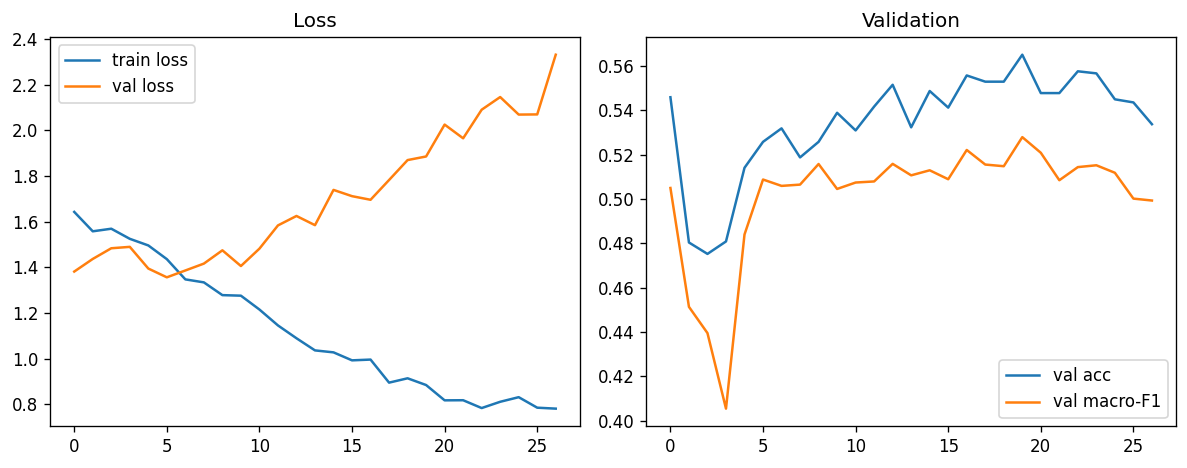

Epoch 27/40 | train_loss=0.7809  val_loss=2.3315  val_acc=0.5337  val_macroF1=0.4993  lr=8.25e-05  time=133.0s
Early stopping — best epoch: 20


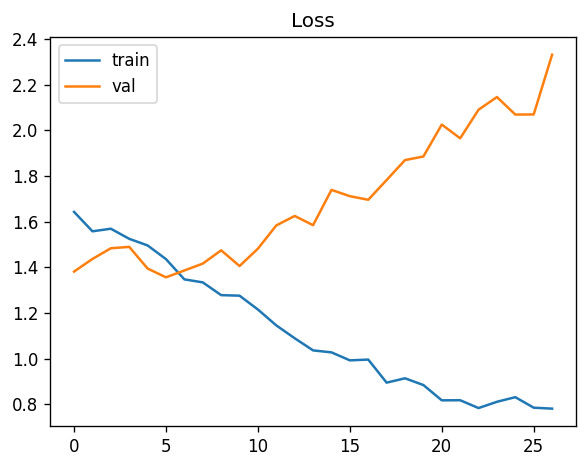

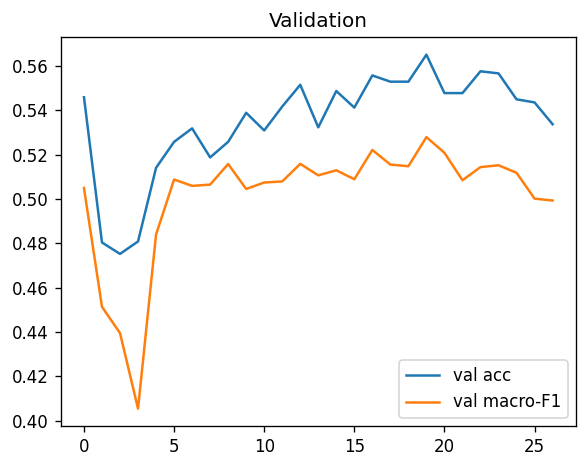

In [9]:
# ===========================
# Cell 6 — Training loop (FP16 + grad accumulation)
# ===========================
best_epoch = -1
history = {"train_loss":[], "val_loss":[], "val_acc":[], "val_f1":[]}

def step_scheduler():  # epoch-wise
    scheduler.step()

for epoch in range(EPOCHS):
    t0 = time.time()
    model.train()
    running = 0.0
    optimizer.zero_grad(set_to_none=True)

    for i, (x,y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            if USE_MIXUP:
                x_mix, y_mix = mixup(x, y)   # y_mix is one-hot (float32)
                logits = model(x_mix)
                # soft-label cross entropy
                loss = -(y_mix * torch.log_softmax(logits, dim=-1)).sum(dim=-1).mean()
            else:
                logits = model(x)
                loss = criterion(logits, y)

        # scale loss for fp16 and accumulate
        loss = loss / ACCUM_STEPS
        scaler.scale(loss).backward()

        if (i + 1) % ACCUM_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        running += (loss.item() * x.size(0) * ACCUM_STEPS)  # unscale for logging

    train_loss = running / len(train_loader.dataset)

    # ---- Validation (AMP off; use fp16 autocast for speed but no scaling) ----
    model.eval()
    val_running, ys, ps = 0.0, [], []
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(x)
                vloss = criterion(logits, y)
            val_running += vloss.item() * x.size(0)
            ps.append(torch.argmax(logits, 1).cpu().numpy())
            ys.append(y.cpu().numpy())
    y_true = np.concatenate(ys); y_pred = np.concatenate(ps)
    val_loss = val_running / len(val_loader.dataset)
    val_acc  = accuracy_score(y_true, y_pred)
    val_f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    step_scheduler()

    # live plot
    clear_output(wait=True)
    fig,ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(history["train_loss"], label="train loss"); ax[0].plot(history["val_loss"], label="val loss"); ax[0].legend(); ax[0].set_title("Loss")
    ax[1].plot(history["val_acc"], label="val acc"); ax[1].plot(history["val_f1"], label="val macro-F1"); ax[1].legend(); ax[1].set_title("Validation")
    plt.tight_layout(); plt.show()

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  "
          f"val_acc={val_acc:.4f}  val_macroF1={val_f1:.4f}  lr={optimizer.param_groups[0]['lr']:.2e}  "
          f"time={time.time()-t0:.1f}s")

    # early stopping on macro-F1
    if epoch == 0 or val_f1 >= max(history["val_f1"][:-1]):
        torch.save({"state_dict": model.state_dict(), "best_macro_f1": val_f1}, Path(OUT_DIR)/"best.pth")
        best_epoch = epoch
    elif len(history["val_f1"]) - 1 - best_epoch >= PATIENCE:
        print(f"Early stopping — best epoch: {best_epoch+1}")
        break

# save curves
plt.figure(figsize=(5,4)); plt.plot(history["train_loss"],label="train"); plt.plot(history["val_loss"],label="val"); plt.legend(); plt.title("Loss"); plt.tight_layout(); plt.savefig(Path(OUT_DIR)/"loss_curve.png")
plt.figure(figsize=(5,4)); plt.plot(history["val_acc"],label="val acc"); plt.plot(history["val_f1"],label="val macro-F1"); plt.legend(); plt.title("Validation"); plt.tight_layout(); plt.savefig(Path(OUT_DIR)/"val_metrics.png")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: Us

[VAL] acc=0.5655  macro-F1=0.5281


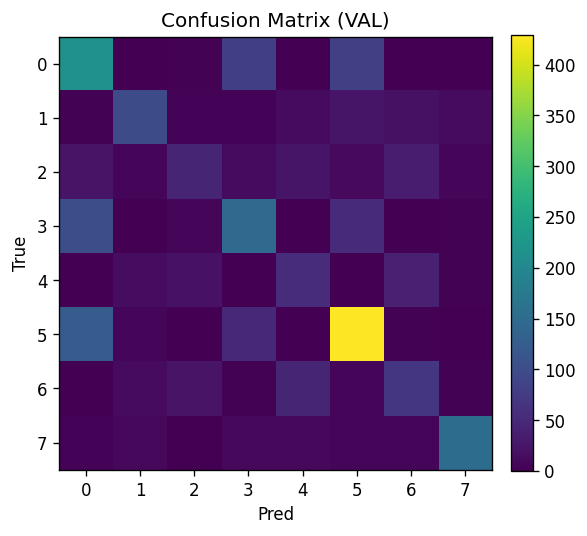

              precision    recall  f1-score   support

         0-0     0.4568    0.5696    0.5070       381
         1-1     0.6490    0.5506    0.5957       178
         2-2     0.4286    0.2778    0.3371       162
         3-3     0.4836    0.4682    0.4757       314
         4-4     0.3776    0.4091    0.3927       132
         5-5     0.7010    0.6987    0.6998       614
         6-6     0.4000    0.4277    0.4134       159
         7-7     0.8483    0.7626    0.8032       198

    accuracy                         0.5655      2138
   macro avg     0.5431    0.5205    0.5281      2138
weighted avg     0.5719    0.5655    0.5657      2138



TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [10]:
# =========================================
# Cell 7 — Best checkpoint & evaluation
# =========================================
ckpt = torch.load(Path(OUT_DIR)/"best.pth", map_location=device)
model.load_state_dict(ckpt["state_dict"])
use_model = model

# Validation
val_acc, val_f1, y_true_v, y_pred_v = evaluate(use_model, val_loader)
print(f"[VAL] acc={val_acc:.4f}  macro-F1={val_f1:.4f}")

# Confusion matrix + report
cm = confusion_matrix(y_true_v, y_pred_v, labels=list(range(len(classes))))
fig, ax = plt.subplots(figsize=(5,5)); im=ax.imshow(cm, cmap='viridis')
ax.set_title("Confusion Matrix (VAL)"); ax.set_xlabel("Pred"); ax.set_ylabel("True")
ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
ax.set_xticklabels(range(len(classes)), rotation=0); ax.set_yticklabels(range(len(classes)))
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04); plt.tight_layout()
plt.savefig(Path(OUT_DIR)/"cm_val.png"); plt.show()

rep_txt = classification_report(y_true_v, y_pred_v,
                                target_names=[f"{i}-{c}" for i,c in enumerate(classes)],
                                zero_division=0, digits=4)
print(rep_txt)
Path(OUT_DIR/"val_report.txt").write_text(rep_txt)
pd.DataFrame({"y_true":y_true_v, "y_pred":y_pred_v}).to_csv(Path(OUT_DIR)/"val_predictions.csv", index=False)

# Test (optional)
if test_loader:
    test_acc, test_f1, y_true_t, y_pred_t = evaluate(use_model, test_loader)
    print(f"[TEST] acc={test_acc:.4f}  macro-F1={test_f1:.4f}")
    cm_t = confusion_matrix(y_true_t, y_pred_t, labels=list(range(len(classes))))
    fig, ax = plt.subplots(figsize=(5,5)); im=ax.imshow(cm_t, cmap='viridis')
    ax.set_title("Confusion Matrix (TEST)"); ax.set_xlabel("Pred"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04); plt.tight_layout()
    plt.savefig(Path(OUT_DIR)/"cm_test.png"); plt.show()
    rep_t = classification_report(y_true_t, y_pred_t,
                                  target_names=[f"{i}-{c}" for i,c in enumerate(classes)],
                                  zero_division=0, digits=4)
    print(rep_t); Path(OUT_DIR/"test_report.txt").write_text(rep_t)
    pd.DataFrame({"y_true":y_true_t, "y_pred":y_pred_t}).to_csv(Path(OUT_DIR)/"test_predictions.csv", index=False)

print("All outputs saved to:", OUT_DIR)

In [ ]:
# =========================================
# Cell 8 — (Optional) Export to ONNX
# =========================================
onnx_path = str(Path(OUT_DIR)/f"{BACKBONE}_emotions.onnx")
use_model.eval()
dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=device)
torch.onnx.export(use_model, dummy, onnx_path,
                  input_names=["input"], output_names=["logits"],
                  dynamic_axes={"input":{0:"batch"}, "logits":{0:"batch"}},
                  opset_version=13)
print("Saved ONNX:", onnx_path)